In [3]:
import sys
sys.path.append('../') # or just install the module
sys.path.append('../../fuzzy-torch') # or just install the module
sys.path.append('../../fuzzy-tools') # or just install the module
sys.path.append('../../astro-lightcurves-handler') # or just install the module

In [4]:
import argparse
from fuzzytools.prints import print_big_bar

parser = argparse.ArgumentParser('usage description')
parser.add_argument('-method',  type=str, default='spm-mcmc-estw', help='method')
parser.add_argument('-gpu',  type=int, default=-1, help='gpu')
parser.add_argument('-mc',  type=str, default='parallel_rnn_models', help='model_collections method')
parser.add_argument('-batch_size',  type=int, default=512, help='batch_size')
parser.add_argument('-load_model',  type=bool, default=False, help='load_model')
parser.add_argument('-epochs_max',  type=int, default=1e4, help='epochs_max')
parser.add_argument('-save_rootdir',  type=str, default='../save', help='save_rootdir')
parser.add_argument('-iid',  type=int, default=0, help='initial id')
parser.add_argument('-fid',  type=int, default=5, help='final id')
parser.add_argument('-kf',  type=str, default='0', help='kf')
parser.add_argument('-rsc',  type=int, default=3, help='random_subcrops')
parser.add_argument('-upc',  type=int, default=True, help='precompute')
main_args = parser.parse_args(['-gpu', '-1', '-upc', '0'])
#main_args = parser.parse_args()
print_big_bar()

▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀


In [5]:
###################################################################################################################################################
from fuzzytools.files import search_for_filedirs
from lchandler import C_ as C_

surveys_rootdir = '../../surveys-save/'
filedirs = search_for_filedirs(surveys_rootdir, fext=C_.EXT_SPLIT_LIGHTCURVE)

────────────────────────────────────────────────────────────────────────────────────────────────────
found filedirs: (../../surveys-save/)
(0) - ../../surveys-save/alerceZTFv7.1/survey=alerceZTFv7.1°bands=gr°mode=onlySNe°method=spm-mcmc-estw.splcds - 79.724[mbs]
────────────────────────────────────────────────────────────────────────────────────────────────────
filedirs after searching with filters: (../../surveys-save/)
(0) - ../../surveys-save/alerceZTFv7.1/survey=alerceZTFv7.1°bands=gr°mode=onlySNe°method=spm-mcmc-estw.splcds - 79.724[mbs]
────────────────────────────────────────────────────────────────────────────────────────────────────


In [6]:
import numpy as np
from fuzzytools.files import load_pickle, save_pickle
from fuzzytools.files import get_dict_from_filedir

filedir = f'../../surveys-save/alerceZTFv7.1/survey=alerceZTFv7.1°bands=gr°mode=onlySNe°method={main_args.method}.splcds'
filedict = get_dict_from_filedir(filedir)
root_folder = filedict['*rootdir*']
cfilename = filedict['*cfilename*']
survey = filedict['survey']
lcdataset = load_pickle(filedir)
print(lcdataset)

> loading: ../../surveys-save/alerceZTFv7.1/survey=alerceZTFv7.1°bands=gr°mode=onlySNe°method=spm-mcmc-estw.splcds
LCDataset:
[outliers - samples 10]
(.) obs_samples: 541 - min_len: 14 - max_dur: 408.0[days] - dur(p50): 133.8[days] - cadence(p50): 1.0[days]
(g) obs_samples: 260 - min_len: 6 - max_dur: 408.0[days] - dur(p50): 133.8[days] - cadence(p50): 3.0[days]
(r) obs_samples: 281 - min_len: 8 - max_dur: 376.0[days] - dur(p50): 128.7[days] - cadence(p50): 3.0[days]
   |█▌      | SLSN - 2/10 (20.00%)
   |▊       | SNIa - 1/10 (10.00%)
   |█▌      | SNIbc - 2/10 (20.00%)
   |████    | allSNII - 5/10 (50.00%)
────────────────────────────────────────────────────────────────────────────────────────────────────
[faint - samples 48]
(.) obs_samples: 1,107 - min_len: 7 - max_dur: 298.1[days] - dur(p50): 40.5[days] - cadence(p50): 1.0[days]
(g) obs_samples: 450 - min_len: 0 - max_dur: 221.7[days] - dur(p50): 28.0[days] - cadence(p50): 2.9[days]
(r) obs_samples: 657 - min_len: 4 - max_dur: 298

In [7]:
from lcclassifier.models.model_collections import ModelCollections

model_collections = ModelCollections(lcdataset)
#getattr(model_collections, main_args.mc)()
#getattr(model_collections, 'parallel_rnn_models_dt')()
#getattr(model_collections, 'parallel_rnn_models_te')()
#getattr(model_collections, 'serial_rnn_models_dt')()
#getattr(model_collections, 'serial_rnn_models_te')()
#getattr(model_collections, 'parallel_tcnn_models_dt')()
#getattr(model_collections, 'parallel_tcnn_models_te')()
#getattr(model_collections, 'serial_tcnn_models_te')()
getattr(model_collections, 'parallel_atcnn_models_te')()
#getattr(model_collections, 'serial_atcnn_models_te')()
print(model_collections)

(0) - mdl_kwargs: {'C': <class 'lcclassifier.models.model_baselines.ParallelAttnTCNNClassifier'>, 'tcnn_embd_dims': 30, 'tcnn_layers': 2, 'dropout': {'p': 0.25}, 'band_names': ['g', 'r'], 'output_dims': 4}
(0) - dataset_kwargs: {'in_attrs': ['obs', 'obse'], 'rec_attr': 'obs', 'max_day': 150.0, 'te_features': 8}
(0) - dec_mdl_kwargs: {'C': <class 'lcclassifier.models.rnn.decoders.RNNDecoderS'>, 'rnn_cell_name': 'GRU', 'rnn_layers': 1, 'dropout': {'p': 0.25}, 'band_names': ['g', 'r'], 'output_dims': 4}
(0) - class_mdl_kwargs: {'C': <class 'lcclassifier.models.classifiers.SimpleClassifier'>, 'embd_layers': 1, 'dropout': {'p': 0.25}, 'band_names': ['g', 'r'], 'output_dims': 4}
---
(1) - mdl_kwargs: {'C': <class 'lcclassifier.models.model_baselines.ParallelAttnTCNNClassifier'>, 'tcnn_embd_dims': 60, 'tcnn_layers': 2, 'dropout': {'p': 0.25}, 'band_names': ['g', 'r'], 'output_dims': 4}
(1) - dataset_kwargs: {'in_attrs': ['obs', 'obse'], 'rec_attr': 'obs', 'max_day': 150.0, 'te_features': 8}
(

In [6]:
### LOSS & METRICS
from lcclassifier.losses import LCMSEReconstruction, LCXEntropy, LCCompleteLoss
from lcclassifier.metrics import LCXEntropyMetric, LCAccuracy

loss_kwargs = {
    'model_output_is_with_softmax':False,
    'target_is_onehot':False,
    'uses_poblation_weights':True,
}
#pt_loss = LCCompleteLoss('wmse', lcdataset['raw'].band_names)
#pt_loss = LCXEntropy('wxentropy', **loss_kwargs)
pt_loss = LCCompleteLoss('wmse-xentropy', lcdataset['raw'].band_names, **loss_kwargs)
pt_metrics = [
    LCXEntropyMetric('xentropy', **loss_kwargs),
    LCAccuracy('b-accuracy', balanced=True, **loss_kwargs),
    LCAccuracy('accuracy', **loss_kwargs),
]

In [7]:
import os
if main_args.gpu>=0:
    os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID' # see issue #152
    os.environ['CUDA_VISIBLE_DEVICES'] = str(main_args.gpu) # CUDA-GPU

In [8]:
%load_ext autoreload
%autoreload 2
### GRID
from lcclassifier.datasets import CustomDataset
from lcclassifier.dataloaders import CustomDataLoader

for mp_grid in model_collections.pms:
    ### DATASETS
    dataset_kwargs = mp_grid['dataset_kwargs']
    s_train_dataset = CustomDataset(lcdataset, f'{main_args.kf}@train.{main_args.method}', **dataset_kwargs)
    s_val_dataset = CustomDataset(lcdataset, f'{main_args.kf}@val.{main_args.method}', **dataset_kwargs)
    r_train_dataset = CustomDataset(lcdataset, f'{main_args.kf}@train', **dataset_kwargs)
    r_val_dataset = CustomDataset(lcdataset, f'{main_args.kf}@val', **dataset_kwargs)

    mp_grid['mdl_kwargs']['curvelength_max'] = s_train_dataset.get_max_len()
    mp_grid['dec_mdl_kwargs']['curvelength_max'] = s_train_dataset.get_max_len()
    s_train_dataset.transfer_metadata_to(s_val_dataset) # transfer metadata to val/test
    s_train_dataset.transfer_metadata_to(r_train_dataset) # transfer metadata to val/test
    s_train_dataset.transfer_metadata_to(r_val_dataset) # transfer metadata to val/test

    print('s_train_dataset:', s_train_dataset)
    print('s_val_dataset:', s_val_dataset)
    print('r_train_dataset:', r_train_dataset)
    print('r_val_dataset:', r_val_dataset)
    
    if main_args.upc:
        synth_precomputed_samples = 4
        real_precomputed_samples = synth_precomputed_samples*32
        s_train_dataset.precompute_samples(synth_precomputed_samples)
        s_val_dataset.precompute_samples(synth_precomputed_samples)
        r_train_dataset.precompute_samples(real_precomputed_samples)
        r_val_dataset.precompute_samples(real_precomputed_samples)

    ### DATALOADERS
    loader_kwargs = {
        #'num_workers':2, # bug?
        'batch_size':main_args.batch_size,
        'random_subcrops':main_args.rsc,
    }
    s_train_loader = CustomDataLoader(s_train_dataset, shuffle=True, **loader_kwargs)
    s_val_loader = CustomDataLoader(s_val_dataset, shuffle=False, **loader_kwargs)
    r_train_loader = CustomDataLoader(r_train_dataset, shuffle=True, **loader_kwargs)
    r_val_loader = CustomDataLoader(r_val_dataset, shuffle=False, **loader_kwargs)

    ### IDS
    model_ids = list(range(main_args.iid, main_args.fid+1))
    for ki,model_id in enumerate(model_ids): # IDS
        ### GET MODEL
        mdl_kwargs = mp_grid['mdl_kwargs']
        for k_ in ['mdl_kwargs', 'dec_mdl_kwargs']:
            mp_grid[k_]['input_dims'] = s_train_loader.dataset.get_output_dims()
            mp_grid[k_]['te_features'] = s_train_loader.dataset.get_te_features_dims()
            #mp_grid[k_]['curvelength_max'] = s_train_dataset.get_max_len()

        model = mdl_kwargs['C'](**mp_grid)

        ### OPTIMIZER
        import torch.optim as optims
        from fuzzytorch.optimizers import LossOptimizer

        decay_kwargs = {
            'lr':0.95,
        }
        pt_optimizer_kwargs = {
            'opt_kwargs':{
                'lr':.5e-3,
            },
            #'decay_kwargs':decay_kwargs,
        }
        pt_optimizer = LossOptimizer(model, optims.Adam, **pt_optimizer_kwargs)

        ### MONITORS
        from fuzzytools.prints import print_bar
        from fuzzytorch.handlers import ModelTrainHandler
        from fuzzytorch.monitors import LossMonitor
        from fuzzytorch import C_
        import math

        monitor_config = {
            'val_epoch_counter_duration':1, # every k epochs check
            'earlystop_epoch_duration':20,
            #'save_mode':C_.SM_NO_SAVE,
            #'save_mode':C_.SM_ALL,
            #'save_mode':C_.SM_ONLY_ALL,
            #'save_mode':C_.SM_ONLY_INF_METRIC,
            'save_mode':C_.SM_ONLY_INF_LOSS,
            #'save_mode':C_.SM_ONLY_SUP_METRIC,
        }
        pt_loss_monitors = LossMonitor(pt_loss, pt_optimizer, pt_metrics, **monitor_config)

        ### TRAIN
        mtrain_config = {
            'id':model_id,
            'epochs_max':1e5,
            'save_rootdir':f'../save/training',
            'extra_model_name_dict':{
                'mode':'pt',
                #'ef-be':f'1e{math.log10(s_train_loader.dataset.effective_beta_eps)}',
                'ef-be':s_train_loader.dataset.effective_beta_eps,
                'rsc':main_args.rsc,
            },
            'uses_train_eval_loader_methods':True,
        }
        model_train_handler = ModelTrainHandler(model, pt_loss_monitors, **mtrain_config)
        model_train_handler.build_gpu(0 if main_args.gpu>=0 else None)
        if ki==0:
            print(model_train_handler)
        assert 0
        model_train_handler.fit_loader(s_train_loader, s_val_loader) # main fit


/home/opimentel/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/preprocessing/data.py:2239: UserWarning: n_quantiles (5000) is greater than the total number of samples (4866). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))
/home/opimentel/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/preprocessing/data.py:2239: UserWarning: n_quantiles (5000) is greater than the total number of samples (4866). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))


s_train_dataset: CustomDataset(lcset_len=37,248, max_day=120.00, max_len=186, te_periods=[240.0, 120.0, 60.0, 30.0], in_attrs=['obs', 'obse'], rec_attr=obs, poblation_weights={'SLSN': 0.7291233584095902, 'SNIa': 0.031563476408803796, 'SNIbc': 0.17818648348150024, 'allSNII': 0.06112668170010587})
s_val_dataset: CustomDataset(lcset_len=12,384, max_day=120.00, max_len=170, te_periods=[240.0, 120.0, 60.0, 30.0], in_attrs=['obs', 'obse'], rec_attr=obs, poblation_weights={'SLSN': 0.7688628832401817, 'SNIa': 0.016006571184032144, 'SNIbc': 0.1657734372665637, 'allSNII': 0.04935710830922252})
r_train_dataset: CustomDataset(lcset_len=1,164, max_day=120.00, max_len=147, te_periods=[240.0, 120.0, 60.0, 30.0], in_attrs=['obs', 'obse'], rec_attr=obs, poblation_weights={'SLSN': 0.7651075333352791, 'SNIa': 0.011723248920097532, 'SNIbc': 0.17488232279678406, 'allSNII': 0.048286894947839325})
r_val_dataset: CustomDataset(lcset_len=387, max_day=120.00, max_len=129, te_periods=[240.0, 120.0, 60.0, 30.0], 

../../fuzzy-torch/fuzzytorch/handlers.py:62: UserWarning: there is not CUDA nor GPUs... Using CPU >:(
  warnings.warn('there is not CUDA nor GPUs... Using CPU >:(')


AssertionError: 

TypeError: 'NoneType' object is not subscriptable

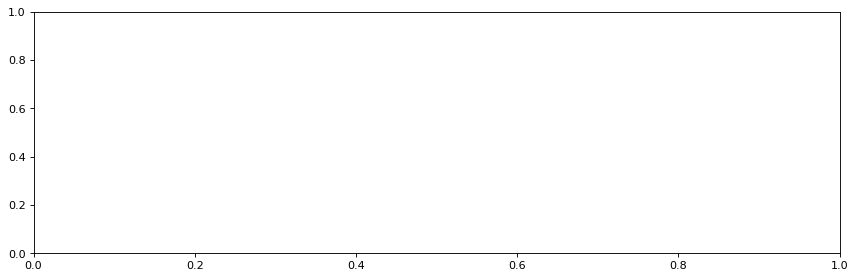

In [9]:
import fuzzytorch
import fuzzytorch.plots
import fuzzytorch.plots.training as ffplots

### training plots
plot_kwargs = {
    'save_rootdir':f'../save/train_plots',
}
ffplots.plot_loss(model_train_handler, **plot_kwargs)
#ffplots.plot_evaluation_loss(train_handler, **plot_kwargs)
#ffplots.plot_evaluation_metrics(train_handler, **plot_kwargs)

In [15]:
%load_ext autoreload
%autoreload 2
import lcclassifier.experiments.images as exp_img

### perform the experiments
exp_kwargs = {
    'save_rootdir':f'../save/experiments',
    'm':4,
}
#exp_img.reconstructions(model_train_handler, s_train_loader, **exp_kwargs)
exp_img.reconstructions_m(model_train_handler, s_val_loader, **exp_kwargs)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
> loading model: ../save/training/mdl=ParallelAttnTCNn°in-dims=2°te-dims=8°enc-emb=g64.g64.g64-r64.r64.r64°dec-emb=64-64°mode=pt°ef-be=0.0001°rsc=3/id=0°epoch=2.tfes
> saving: ../save/experiments/mdl=ParallelAttnTCNn°in-dims=2°te-dims=8°enc-emb=g64.g64.g64-r64.r64.r64°dec-emb=64-64°mode=pt°ef-be=0.0001°rsc=3/exp_id=0°id=0°set=0@val.spm-mcmc-estw.png
> loading model: ../save/training/mdl=ParallelAttnTCNn°in-dims=2°te-dims=8°enc-emb=g64.g64.g64-r64.r64.r64°dec-emb=64-64°mode=pt°ef-be=0.0001°rsc=3/id=0°epoch=2.tfes
> saving: ../save/experiments/mdl=ParallelAttnTCNn°in-dims=2°te-dims=8°enc-emb=g64.g64.g64-r64.r64.r64°dec-emb=64-64°mode=pt°ef-be=0.0001°rsc=3/exp_id=1°id=0°set=0@val.spm-mcmc-estw.png
> loading model: ../save/training/mdl=ParallelAttnTCNn°in-dims=2°te-dims=8°enc-emb=g64.g64.g64-r64.r64.r64°dec-emb=64-64°mode=pt°ef-be=0.0001°rsc=3/id=0°epoch=2.tfes
> saving: ../save/experiments/mdl=Parallel

['../save/experiments/mdl=ParallelAttnTCNn°in-dims=2°te-dims=8°enc-emb=g64.g64.g64-r64.r64.r64°dec-emb=64-64°mode=pt°ef-be=0.0001°rsc=3/exp_id=0°id=0°set=0@val.spm-mcmc-estw.png',
 '../save/experiments/mdl=ParallelAttnTCNn°in-dims=2°te-dims=8°enc-emb=g64.g64.g64-r64.r64.r64°dec-emb=64-64°mode=pt°ef-be=0.0001°rsc=3/exp_id=1°id=0°set=0@val.spm-mcmc-estw.png',
 '../save/experiments/mdl=ParallelAttnTCNn°in-dims=2°te-dims=8°enc-emb=g64.g64.g64-r64.r64.r64°dec-emb=64-64°mode=pt°ef-be=0.0001°rsc=3/exp_id=2°id=0°set=0@val.spm-mcmc-estw.png',
 '../save/experiments/mdl=ParallelAttnTCNn°in-dims=2°te-dims=8°enc-emb=g64.g64.g64-r64.r64.r64°dec-emb=64-64°mode=pt°ef-be=0.0001°rsc=3/exp_id=3°id=0°set=0@val.spm-mcmc-estw.png']

In [28]:
%load_ext autoreload
%autoreload 2
import lcclassifier.experiments.performance as exp_perf

### perform the experiments
exp_kwargs = {
    'save_rootdir':f'../save/experiments',
    'target_is_onehot':False,
}
#exp_perf.reconstruction_along_days(model_train_handler, s_train_loader, **exp_kwargs)
exp_perf.reconstruction_along_days(model_train_handler, s_val_loader, **exp_kwargs)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
> loading model: ../save/training/mdl=ParallelAttnTCNn°in-dims=2°te-dims=8°enc-emb=g64.g64.g64-r64.r64.r64°dec-emb=64-64°mode=pt°ef-be=0.0001°rsc=3/id=0°epoch=8.tfes
  2%|▏         | 1/50 [00:05,  5.02s/it, day: 2.0000/120.0000 - mse_loss: 1702.9423828125 - ase_loss: 5974.20263671875]
{'days': array([  2.        ,   4.40816327,   6.81632653,   9.2244898 ,
        11.63265306,  14.04081633,  16.44897959,  18.85714286,
        21.26530612,  23.67346939,  26.08163265,  28.48979592,
        30.89795918,  33.30612245,  35.71428571,  38.12244898,
        40.53061224,  42.93877551,  45.34693878,  47.75510204,
        50.16326531,  52.57142857,  54.97959184,  57.3877551 ,
        59.79591837,  62.20408163,  64.6122449 ,  67.02040816,
        69.42857143,  71.83673469,  74.24489796,  76.65306122,
        79.06122449,  81.46938776,  83.87755102,  86.28571429,
        88.69387755,  91.10204082,  93.51020408,  

In [1]:
%load_ext autoreload
%autoreload 2
import lcclassifier.experiments.performance as exp_perf

### perform the experiments
exp_kwargs = {
    'save_rootdir':f'../save/experiments',
    'target_is_onehot':False,
}
#exp_perf.metrics_along_days(model_train_handler, s_val_loader, **exp_kwargs)
exp_perf.metrics_along_days(model_train_handler, s_val_loader, **exp_kwargs)

ModuleNotFoundError: No module named 'lcclassifier'